# Coordinate Transform

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
R_LONG = 6378137
R_SHORT = 6356752.3142
E_EARTH: np.float64 = np.sqrt(1 - (R_SHORT / R_LONG) ** 2)

# MEAN_ALTITUDE = 12.711403


def lla_to_ecef(lon_rad, lat_rad, alt):
    N = R_LONG / np.sqrt(1 - E_EARTH ** 2 * np.sin(lat_rad))
    return (
        (N + alt) * np.cos(lat_rad) * np.cos(lon_rad),
        (N + alt) * np.cos(lat_rad) * np.sin(lon_rad),
        (N * (R_LONG / R_SHORT) ** 2 + alt) * np.sin(lat_rad),
    )

## Data Loading

In [ ]:
lla_labels = ["gps_latitude", "gps_longitude", "gps_altitude"]
# lla_labels = [label[:7] + "_integrated" for label in lla_labels]

df_log = pd.read_csv(
    "./coordinate_transform.csv",
    index_col=0,
)
df_src_raw = df_log[[
    "valid",
    "x_center",
    "y_center",
    "x_estimate",
    "y_estimate",
    "heading",
    "gps_latitude",
    "gps_longitude",
    "gps_altitude",
    "gps_lat_integrated",
    "gps_lon_integrated",
    "gps_alt_integrated",
]]
df_src = df_src_raw.loc[
    (df_src_raw["valid"] == 1)
    & (df_src_raw[lla_labels[0]] != 0)
    & (df_src_raw[lla_labels[1]] != 0)
    & (df_src_raw[lla_labels[2]] != 0)
    & ((df_src_raw["x_center"] != df_src_raw["x_estimate"])
        | (df_src_raw["y_center"] != df_src_raw["y_estimate"]))
    & np.isfinite(df_src_raw[lla_labels[0]])
    & np.isfinite(df_src_raw[lla_labels[1]])
    & np.isfinite(df_src_raw[lla_labels[2]])
]
n_src = len(df_src)
print(f"{n_src} out of {len(df_src_raw)} samples selected")

lat = df_src[lla_labels[0]].to_numpy()
lon = df_src[lla_labels[1]].to_numpy()
alt = df_src[lla_labels[2]].to_numpy()
heading = df_src["heading"].to_numpy()
x_center = df_src["x_center"].to_numpy()
y_center = df_src["y_center"].to_numpy()

column_shape = (n_src, 1)
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

473 out of 7428 samples selected


In [4]:
# i_0 = 0
i_0 = n_src // 4
lat0_rad, lon0_rad, alt0, x0_center, y0_center, heading_0 = \
    lat_rad[i_0], lon_rad[i_0], alt[i_0], x_center[i_0], y_center[i_0], heading[i_0]
ecef_x0, ecef_y0, ecef_z0 = \
    lla_to_ecef(lon0_rad, lat0_rad, alt0)


def ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z):
    ecef_dx = ecef_x - ecef_x0
    ecef_dy = ecef_y - ecef_y0
    ecef_dz = ecef_z - ecef_z0
    e = -np.sin(lon_rad) * ecef_dx + np.cos(lon_rad) * ecef_dy
    n = -np.cos(lon_rad) * np.sin(lat_rad) * ecef_dx \
        - np.sin(lon_rad) * np.sin(lat_rad) * ecef_dy \
        + np.cos(lat_rad) * ecef_dz
    u = np.cos(lon_rad) * np.cos(lat_rad) * ecef_dx \
        + np.sin(lon_rad) * np.cos(lat_rad) * ecef_dy \
        + np.sin(lat_rad) * ecef_dz
    return e, n, u

### Original LLA

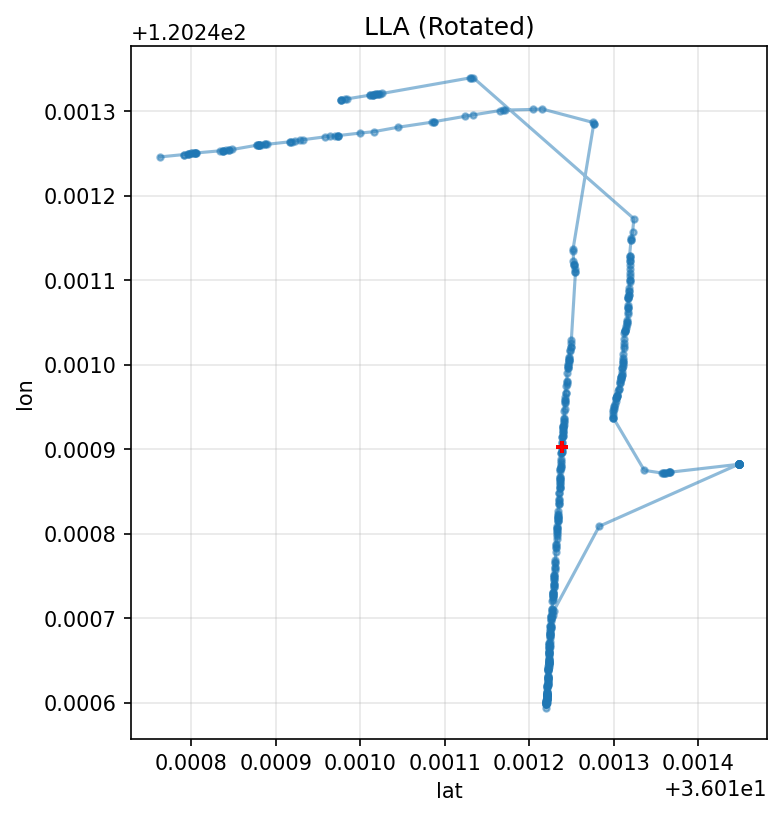

In [5]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ll = np.vstack([lat, lon])
ll_0 = np.array([ll[:, 0].tolist()] * ll.shape[1]).T
rotation = np.deg2rad(180 - 50)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ll_rotated = R @ (ll - ll_0) + ll_0
ax.plot(ll_rotated[0, :], ll_rotated[1, :], ".-", alpha=0.5)

ll_origin = np.vstack([np.rad2deg(lat0_rad), np.rad2deg(lon0_rad)])
ll_origin_rotated = R @ (ll_origin - ll_0) + ll_0
ax.plot(ll_origin_rotated[0, :], ll_origin_rotated[1, :], "r+",
        label="LLA Origin")

ax.set(
    title="LLA (Rotated)",
    xlabel="lat",
    ylabel="lon",
    aspect="equal",
)
ax.grid(alpha=0.3)

### Original ECEF

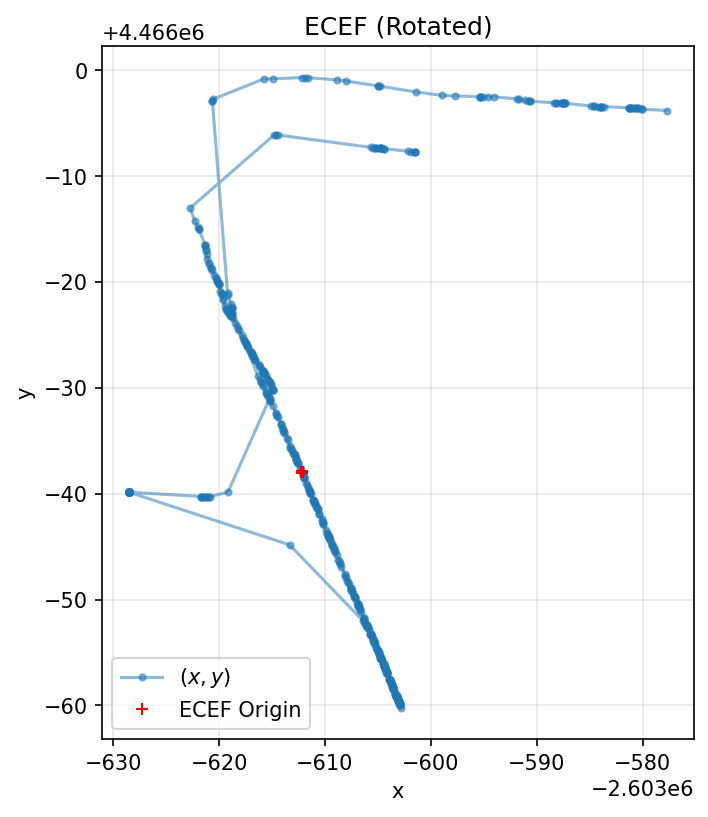

In [6]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ecef_x, ecef_y, ecef_z = \
    lla_to_ecef(lon_rad, lat_rad, alt)
ecef = np.vstack([ecef_x, ecef_y])
ecef_0 = np.array([ecef[:, 0].tolist()] * ecef.shape[1]).T
rotation = np.deg2rad(120)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
ecef_rotated = R @ (ecef - ecef_0) + ecef_0
ax.plot(ecef_rotated[0, :], ecef_rotated[1, :], ".-", alpha=0.5, label="$(x,y)$")

ecef_origin = np.vstack([ecef_x0, ecef_y0])
ecef_origin_rotated = R @ (ecef_origin - ecef_0) + ecef_0
ax.plot(ecef_origin_rotated[0, :], ecef_origin_rotated[1, :], "r+", \
        label="ECEF Origin")

ax.set(
    title="ECEF (Rotated)",
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

### Original ENU

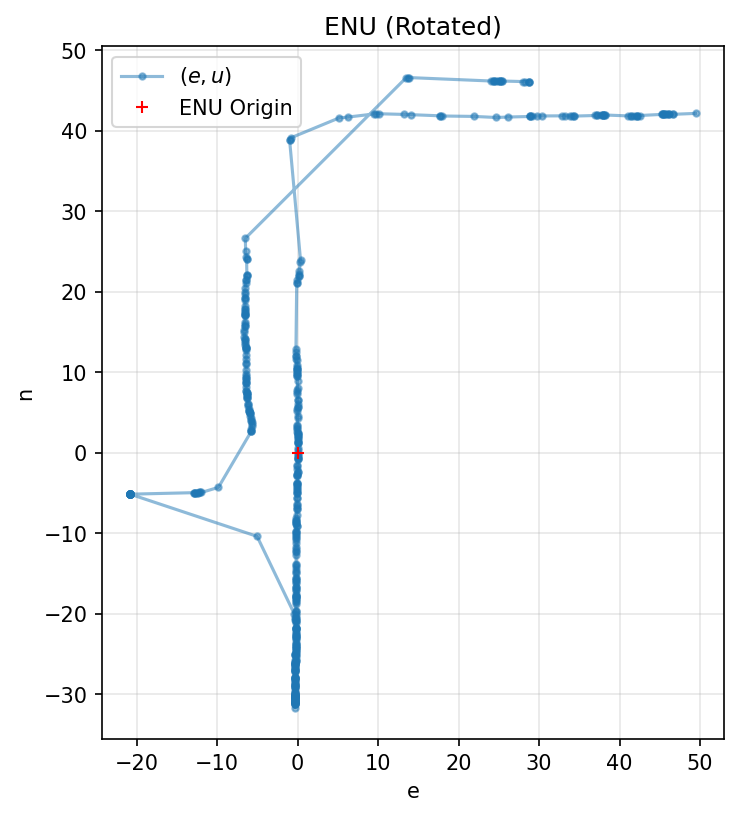

In [7]:
fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

e, n, u = ecef_to_enu(lon_rad, lat_rad, ecef_x, ecef_y, ecef_z)
en = np.vstack([e, n])
rotation = np.deg2rad(-38)
R = np.array([
    [np.cos(rotation), -np.sin(rotation)],
    [np.sin(rotation), np.cos(rotation)],
])
en_rotated = R @ en
ax.plot(en_rotated[0, :], en_rotated[1, :], ".-", alpha=0.5, label="$(e,u)$")

ax.plot(0, 0, "r+", label="ENU Origin")

ax.set(
    title="ENU (Rotated)",
    xlabel="e",
    ylabel="n",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

## Estimate Device Offset

In [8]:
A_est = np.hstack([
    np.cos(heading).reshape(column_shape),
    np.sin(heading).reshape(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    u.reshape(column_shape),
    (e * n).reshape(column_shape),
    (n * u).reshape(column_shape),
    (u * e).reshape(column_shape),
    (e ** 2).reshape(column_shape),
    (n ** 2).reshape(column_shape),
    (u ** 2).reshape(column_shape),
    np.ones(column_shape),
])
b_est = np.hstack([
    # (x_center - x0_center).reshape(column_shape),
    # (y_center - y0_center).reshape(column_shape),
    x_center.reshape(column_shape),
    y_center.reshape(column_shape),
])
(
    solution_est,
    residuals_est,
    rank_est,
    singular_values_est
) = np.linalg.lstsq(A_est, b_est)
estimated_device_x = (np.abs(solution_est[0, 0]) + np.abs(solution_est[1, 1])) / 2
estimated_device_y = (np.abs(solution_est[1, 0]) + np.abs(solution_est[0, 1])) / 2
print("Solution =")
print(solution_est)
print("Residuals =")
print(residuals_est)
print("Rank =")
print(rank_est)
print("Singular Values =")
print(singular_values_est)
print("Estimated Device Offset =")
print(f"({estimated_device_x:.6f}, {estimated_device_y:.6f})")

Solution =
[[ 4.11484093e-01 -2.86495728e+00]
 [ 2.76311073e+00  2.16354575e-01]
 [ 7.83612129e-01 -6.09054655e-01]
 [ 5.99877935e-01  7.85242931e-01]
 [-3.89838206e-01 -2.04324313e-01]
 [ 1.80079087e-04 -4.96011482e-05]
 [-3.47547901e-03  1.10688219e-03]
 [ 7.12870101e-03 -1.00498129e-03]
 [-8.14664256e-04 -6.71528635e-05]
 [ 3.95675879e-04 -1.00826276e-06]
 [-5.29518223e-02 -2.46478838e-02]
 [ 6.04969053e+02  8.74280725e+01]]
Residuals =
[6.12671246 2.82177403]
Rank =
12
Singular Values =
[2.65697399e+04 7.09661478e+03 2.68877422e+03 2.03882702e+03
 9.40010872e+02 2.54113554e+02 1.65703653e+02 7.57189176e+01
 1.53244467e+01 7.05009292e+00 1.70540992e+00 1.19109528e+00]
Estimated Device Offset =
(0.313919, 2.814034)


## Fir Transform Formula

In [9]:
INS_OFFSET_X = 0.465
INS_OFFSET_Y = 2.950
INS_OFFSET_X = estimated_device_x
INS_OFFSET_Y = estimated_device_y


def center_to_ins(center_x, center_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return center_x + offset_x, center_y + offset_y


def ins_to_center(ins_x, ins_y, heading):
    offset_x = INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading)
    offset_y = INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading)
    return ins_x - offset_x, ins_y - offset_y

### INS Ground Truth

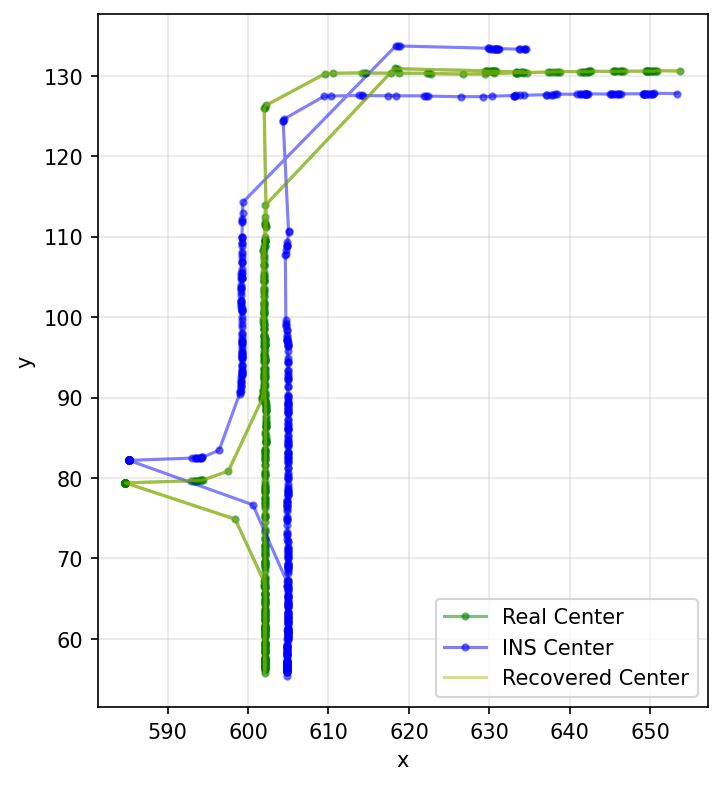

In [10]:
x_ins, y_ins = center_to_ins(x_center, y_center, heading)
x0_ins, y0_ins = center_to_ins(x0_center, y0_center, heading_0)

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.-", alpha=0.5, label="Real Center")
ax.plot(x_ins, y_ins, "b.-", alpha=0.5, label="INS Center")
# ax.plot(x0_ins, y0_ins, "r+", alpha=0.8, label="INS Origin")

x_center_recovered, y_center_recovered = \
    ins_to_center(x_ins, y_ins, heading)
ax.plot(x_center_recovered, y_center_recovered, "y-",
        alpha=0.5, label="Recovered Center")

ax.set(
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

### Fitted Result

Solution =
[[ 6.05027584e+02  8.68974044e+01]
 [ 7.58406532e-01 -6.30523472e-01]
 [ 5.82665705e-01  7.72013633e-01]
 [-4.22567713e-01 -5.76925384e-01]
 [ 3.69509915e-04 -2.38724420e-04]
 [-2.67567779e-03  7.33593895e-04]
 [ 8.34892862e-03 -1.21967334e-03]
 [-1.40811345e-03 -9.61266593e-04]
 [ 9.44304804e-04  3.95562848e-04]
 [-6.25878081e-02 -5.69150735e-02]]
Residuals =
[7.42793247 4.06330227]


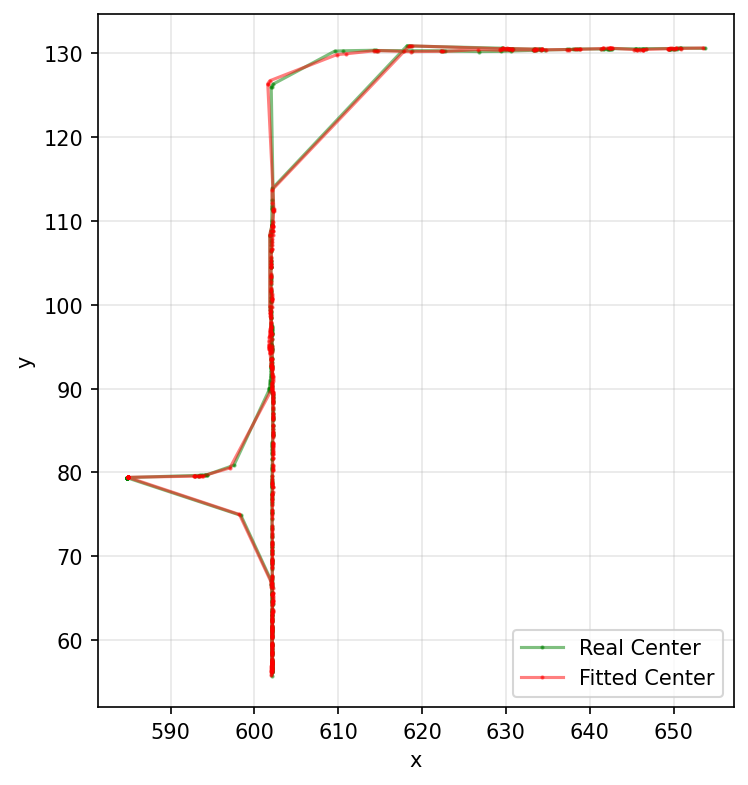

In [11]:
A_fit = np.hstack([
    np.ones(column_shape),
    e.reshape(column_shape),
    n.reshape(column_shape),
    u.reshape(column_shape),
    (e * n).reshape(column_shape),
    (n * u).reshape(column_shape),
    (u * e).reshape(column_shape),
    (e ** 2).reshape(column_shape),
    (n ** 2).reshape(column_shape),
    (u ** 2).reshape(column_shape),
])
b_fit = np.hstack([
    # (x_ins - x0_ins).reshape(column_shape),
    # (y_ins - y0_ins).reshape(column_shape),
    x_ins.reshape(column_shape),
    y_ins.reshape(column_shape),
])
(
    solution_fit,
    residuals_fit,
    rank_fit,
    singular_values_fit
) = np.linalg.lstsq(A_fit, b_fit)
print("Solution =")
print(solution_fit)
print("Residuals =")
print(residuals_fit)
# print("Rank =")
# print(rank_fit)
# print("Singular Values =")
# print(singular_values_fit)

ins_fitted = A_fit @ solution_fit
# x_ins_fitted = ins_fitted[:, 0].ravel() + x0_ins
# y_ins_fitted = ins_fitted[:, 1].ravel() + y0_ins
x_ins_fitted = ins_fitted[:, 0].ravel()
y_ins_fitted = ins_fitted[:, 1].ravel()
x_center_fitted, y_center_fitted = \
    ins_to_center(x_ins_fitted, y_ins_fitted, heading)

fig = plt.figure(figsize=(6, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

ax.plot(x_center, y_center, "g.-", ms=2, alpha=0.5, label="Real Center")
ax.plot(x_center_fitted, y_center_fitted, "r.-", ms=2,
        alpha=0.5, label="Fitted Center")

# ax.plot(x0_center, y0_center, "kx", alpha=0.8, label="Reference Point")

ax.set(
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

P(dis < 0.1) = 0.5983086680761099


,x_center,y_center,x_center_fitted,y_center_fitted,dis
361,594.09,79.70,593.431088,79.568926,0.671822
58,602.01,125.93,601.596145,126.363278,0.599171
359,593.52,79.65,592.933698,79.549829,0.594798
57,602.05,126.00,601.612022,126.386722,0.584276
363,594.33,79.73,593.778870,79.588094,0.569106
365,597.56,80.86,597.088102,80.548965,0.565182
362,594.12,79.71,593.572586,79.572700,0.564370
56,602.23,126.31,601.841872,126.715914,0.561614
54,610.55,130.29,610.913478,129.926150,0.514299
360,593.75,79.67,593.248104,79.563461,0.513079


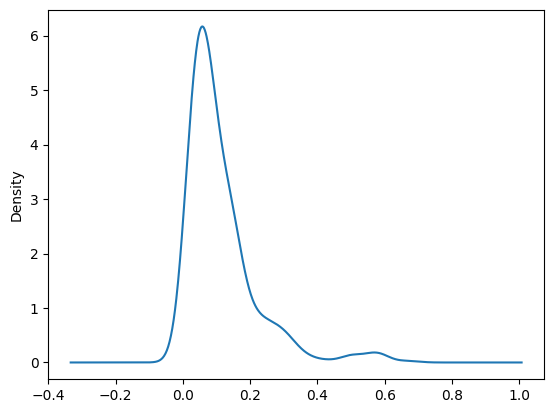

In [12]:
df_comp = pd.DataFrame({
    "x_center": x_center,
    "y_center": y_center,
    "x_center_fitted": x_center_fitted,
    "y_center_fitted": y_center_fitted,
})
dis = np.sqrt(
    (x_center_fitted - x_center) ** 2 + (y_center_fitted - y_center) ** 2
)
df_comp["dis"] = dis

print("P(dis < 0.1) =", (dis < 0.1).sum() / len(dis))

df_comp["dis"].plot.density()

df_comp.sort_values(by="dis", ascending=False, inplace=True)
df_comp.head(10)

In [13]:
print("// 参考坐标")
print(f"const static double ORIGIN_LAT = {np.rad2deg(lat0_rad):.12f}; // ENU 参考点纬度")
print(f"const static double ORIGIN_LON = {np.rad2deg(lon0_rad):.12f}; // ENU 参考点经度")
print(f"const static double ORIGIN_ALT = {alt0:.12f}; // ENU 参考点海拔")
print(f"const double INS_OFFSET_X = {INS_OFFSET_X:.12f}; // 定位点在车身坐标系下的 X 坐标")
print(f"const double INS_OFFSET_Y = {INS_OFFSET_Y:.12f}; // 定位点在车身坐标系下的 Y 坐标")
print()
print("// 计算车辆中心坐标")
print(
    "center_x = %.12f"
    "\n    + INS_OFFSET_X * -cos_heading"
    "\n    + INS_OFFSET_Y * sin_heading"
    "\n    + %.12f * enu_x"
    "\n    + %.12f * enu_y"
    "\n    + %.12f * enu_z"
    "\n    + %.12f * (enu_x * enu_y)"
    "\n    + %.12f * (enu_y * enu_z)"
    "\n    + %.12f * (enu_z * enu_x)"
    "\n    + %.12f * pow(enu_x, 2)"
    "\n    + %.12f * pow(enu_y, 2)"
    "\n    + %.12f * pow(enu_z, 2)"
    ";"
    % tuple(solution_fit[:, 0].ravel())
)
print(
    "center_x = %.12f"
    "\n    + INS_OFFSET_X * -sin_heading"
    "\n    + INS_OFFSET_Y * -cos_heading"
    "\n    + %.12f * enu_x"
    "\n    + %.12f * enu_y"
    "\n    + %.12f * enu_z"
    "\n    + %.12f * (enu_x * enu_y)"
    "\n    + %.12f * (enu_y * enu_z)"
    "\n    + %.12f * (enu_z * enu_x)"
    "\n    + %.12f * pow(enu_x, 2)"
    "\n    + %.12f * pow(enu_y, 2)"
    "\n    + %.12f * pow(enu_z, 2)"
    ";"
    % tuple(solution_fit[:, 1].ravel())
)

// 参考坐标
const static double ORIGIN_LAT = 36.010194400000; // ENU 参考点纬度
const static double ORIGIN_LON = 120.241101900000; // ENU 参考点经度
const static double ORIGIN_ALT = 12.720000000000; // ENU 参考点海拔
const double INS_OFFSET_X = 0.313919334029; // 定位点在车身坐标系下的 X 坐标
const double INS_OFFSET_Y = 2.814034003987; // 定位点在车身坐标系下的 Y 坐标

// 计算车辆中心坐标
center_x = 605.027583807785
    + INS_OFFSET_X * -cos_heading
    + INS_OFFSET_Y * sin_heading
    + 0.758406531503 * enu_x
    + 0.582665705457 * enu_y
    + -0.422567712749 * enu_z
    + 0.000369509915 * (enu_x * enu_y)
    + -0.002675677792 * (enu_y * enu_z)
    + 0.008348928616 * (enu_z * enu_x)
    + -0.001408113454 * pow(enu_x, 2)
    + 0.000944304804 * pow(enu_y, 2)
    + -0.062587808085 * pow(enu_z, 2);
center_x = 86.897404417344
    + INS_OFFSET_X * -sin_heading
    + INS_OFFSET_Y * -cos_heading
    + -0.630523471739 * enu_x
    + 0.772013632684 * enu_y
    + -0.576925384072 * enu_z
    + -0.000238724420 * (enu_x * enu_y)
    + 0.000733593895 *